In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import time
from copy import deepcopy
import matplotlib.pyplot as plt
import os

from utils import *
from PATH import *
from data import *
from train import *
from models import *

from torchinfo import summary

In [13]:
import scipy
import skimage
from skimage import color
import numpy as np
from scipy.sparse.linalg import spsolve
from PIL import Image

#
# fill_depth_colorization.m
# Preprocesses the kinect depth image using a gray scale version of the
# RGB image as a weighting for the smoothing. This code is a slight
# adaptation of Anat Levin's colorization code:
#
# See: www.cs.huji.ac.il/~yweiss/Colorization/
#
# Args:
#  imgRgb - HxWx3 matrix, the rgb image for the current frame. This must
#      be between 0 and 1.
#  imgDepth - HxW matrix, the depth image for the current frame in
#       absolute (meters) space.
#  alpha - a penalty value between 0 and 1 for the current depth values.

def fill_depth_colorization(imgRgb=None, imgDepthInput=None, alpha=1):
	imgIsNoise = imgDepthInput == 0
	maxImgAbsDepth = np.max(imgDepthInput)
	imgDepth = imgDepthInput / maxImgAbsDepth
	imgDepth[imgDepth > 1] = 1
	(H, W) = imgDepth.shape
	numPix = H * W
	indsM = np.arange(numPix).reshape((W, H)).transpose()
	knownValMask = (imgIsNoise == False).astype(int)
	grayImg = skimage.color.rgb2gray(imgRgb)
	winRad = 1
	len_ = 0
	absImgNdx = 0
	len_window = (2 * winRad + 1) ** 2
	len_zeros = numPix * len_window

	cols = np.zeros(len_zeros) - 1
	rows = np.zeros(len_zeros) - 1
	vals = np.zeros(len_zeros) - 1
	gvals = np.zeros(len_window) - 1

	for j in range(W):
		for i in range(H):
			nWin = 0
			for ii in range(max(0, i - winRad), min(i + winRad + 1, H)):
				for jj in range(max(0, j - winRad), min(j + winRad + 1, W)):
					if ii == i and jj == j:
						continue

					rows[len_] = absImgNdx
					cols[len_] = indsM[ii, jj]
					gvals[nWin] = grayImg[ii, jj]

					len_ = len_ + 1
					nWin = nWin + 1

			curVal = grayImg[i, j]
			gvals[nWin] = curVal
			c_var = np.mean((gvals[:nWin + 1] - np.mean(gvals[:nWin+ 1])) ** 2)

			csig = c_var * 0.6
			mgv = np.min((gvals[:nWin] - curVal) ** 2)
			if csig < -mgv / np.log(0.01):
				csig = -mgv / np.log(0.01)

			if csig < 2e-06:
				csig = 2e-06

			gvals[:nWin] = np.exp(-(gvals[:nWin] - curVal) ** 2 / csig)
			gvals[:nWin] = gvals[:nWin] / sum(gvals[:nWin])
			vals[len_ - nWin:len_] = -gvals[:nWin]

	  		# Now the self-reference (along the diagonal).
			rows[len_] = absImgNdx
			cols[len_] = absImgNdx
			vals[len_] = 1  # sum(gvals(1:nWin))

			len_ = len_ + 1
			absImgNdx = absImgNdx + 1

	vals = vals[:len_]
	cols = cols[:len_]
	rows = rows[:len_]
	A = scipy.sparse.csr_matrix((vals, (rows, cols)), (numPix, numPix))

	rows = np.arange(0, numPix)
	cols = np.arange(0, numPix)
	vals = (knownValMask * alpha).transpose().reshape(numPix)
	G = scipy.sparse.csr_matrix((vals, (rows, cols)), (numPix, numPix))

	A = A + G
	b = np.multiply(vals.reshape(numPix), imgDepth.flatten('F'))

	#print ('Solving system..')

	new_vals = spsolve(A, b)
	new_vals = np.reshape(new_vals, (H, W), 'F')

	#print ('Done.')

	denoisedDepthImg = new_vals * maxImgAbsDepth
    
	output = denoisedDepthImg.reshape((H, W)).astype('float32')

	output = np.multiply(output, (1-knownValMask)) + imgDepthInput
    
	return output

[ 0  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79]
(352, 1216)
(352, 1216)


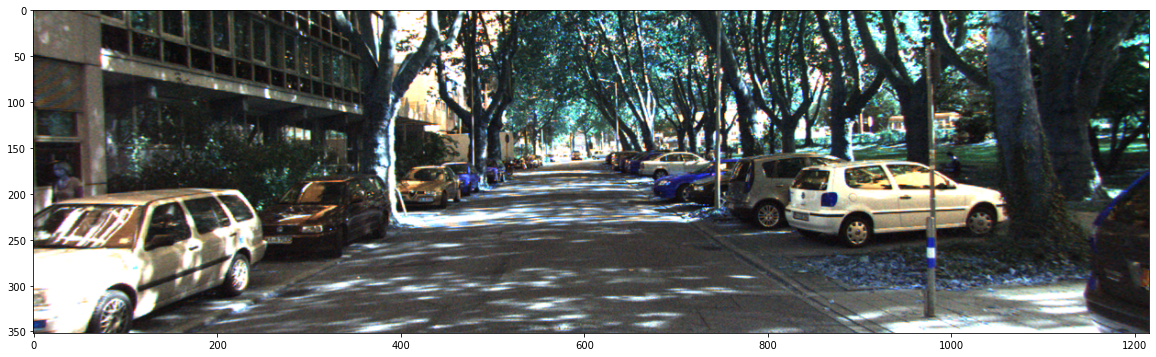

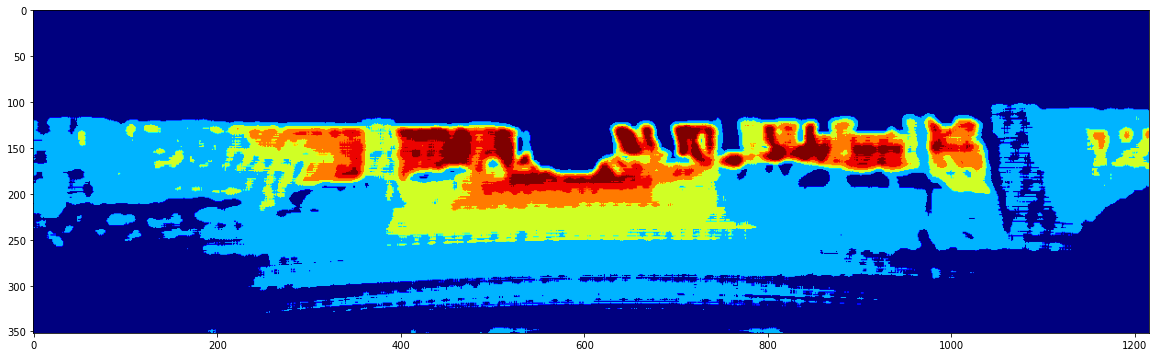

In [40]:
dep = cv2.imread("../../data_depth_selection/depth_selection/test_depth_completion_anonymous/velodyne_raw/0000000000.png")[:,:,0]
img = cv2.imread("../../data_depth_selection/depth_selection/test_depth_completion_anonymous/image/0000000000.png")

print(np.unique(dep))
dep = cv2.GaussianBlur(dep, (15, 15), cv2.BORDER_DEFAULT)

plt.figure(figsize=(20, 10))
plt.imshow(img)
print(dep.shape)

plt.figure(figsize=(20, 10))
plot_depth_map(dep, np.ones_like(dep), "plot.png")
# plot_depth_map(label, np.ones_like(label), os.path.join(save_dir, "label"+str(i)+".png"))
# drawHeatmap(dep)
print(dep.shape)

# dep = fill_depth_colorization(img, dep)
# plt.figure(figsize=(20, 10))
# plot_depth_map(dep, np.ones_like(dep), "plot.png")
# print(dep.shape)

inference takes 0.3213968276977539
unique [ 0.14295998  0.14306775  0.14324343 ... 26.54055    26.647663
 26.71502   ]


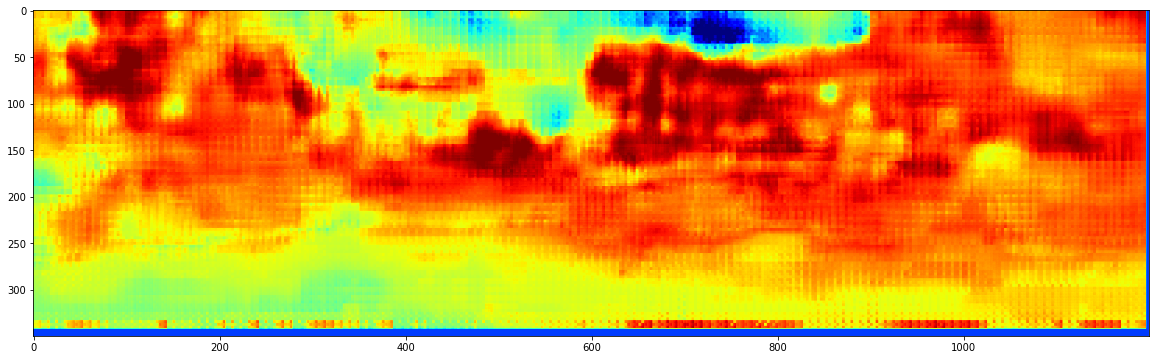

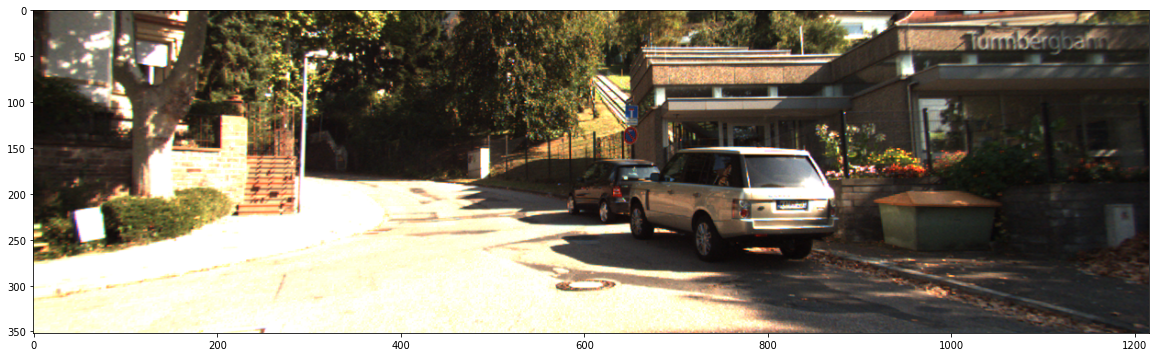

In [51]:
model = torch.load("train-history/trained_model199.pth")
model = model.cpu()
model.eval()

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize( (350, 1200) ),     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img = Image.open("../../data_depth_selection/depth_selection/test_depth_completion_anonymous/image/0000000016.png")
img = img.convert("RGB")  
img_t = preprocess(img)
img_t = img_t.unsqueeze(0)

tic = time.time()
with torch.no_grad():
    pred, _ = model(img_t)
    pred = regPred2Img(pred)
toc = time.time()
print("inference takes", toc-tic)
print("unique", np.unique(pred.numpy()))

plt.figure(figsize=(20, 10))
plot_depth_map(pred, np.ones_like(pred), "plot.png")
plt.figure(figsize=(20, 10))
plt.imshow(img)
# plot_depth_map(label, np.ones_like(label), os.path.join(save_dir, "label"+str(i)+".png"))
# drawHeatmap(dep)